In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from include.Connection import Connection
from include.Tools import *
import pandas as pd
import numpy as np

In [2]:
# filePath = './connection.test.log'
filePath = "./logs/connection.20200507.log"
df = pd.DataFrame()
        
with open(file = filePath, mode = "r", buffering = 1_000_000) as f:
    for line in f:
        keys, values = Connection.parse(line)
        df = df.append(pd.DataFrame(data=[values], columns=keys), ignore_index =True)

df.set_index("ID", inplace=True)

In [ ]:
df.head(5)

In [3]:
# --- Replace unknown user name with "NaN" value:
df["User"] = df["User"].mask(df["User"] == "", "NaN")

In [4]:
users = list(df.groupby("User").groups)

# --- check what we've got:
# users

In [ ]:
# --- check particular user's taffic data:
# df.loc[df["User"] == "UserName"].head(5)

In [5]:
# collect summary data for Pie Chart:
traffic_totals = []

# --- full traffic summary
# for user in users:
#   traffic_totals.append(df.loc[df["User"] == user].groupby(["User"]).agg(np.sum)["Bytes.Total"].values[0])
# traffic_summary = pd.DataFrame({"User": users, "Traffic.MB": list(map(bytes_transform, traffic_totals))})

# --- traffic summary for a custom list of users only:
for user in [user for user in users if user != "NaN"]:
    traffic_totals.append(df.loc[df["User"] == user].groupby(["User"]).agg(np.sum)["Bytes.Total"].values[0])
traffic_summary = pd.DataFrame({"User": [user for user in users if user != "NaN"], "Traffic.MB": list(map(bytes_transform, traffic_totals))})

# --- check what we've got:
traffic_summary

,User,Traffic.MB
0,Pavel,541.36
1,Veronika,667.87
2,Vicky,560.06


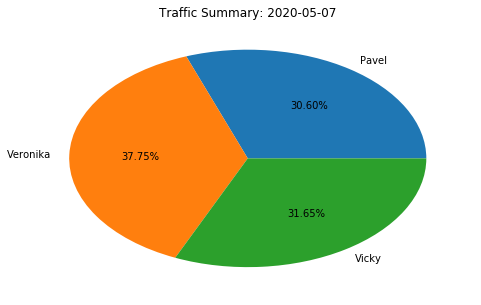

In [6]:
# --- Build a Pie Chart out of summary data:
plt.figure(figsize=(8,5))
plt.pie(traffic_summary["Traffic.MB"], labels=traffic_summary["User"], autopct="%.2f%%")
plt.title("Traffic Summary: 2020-05-07")
plt.show()

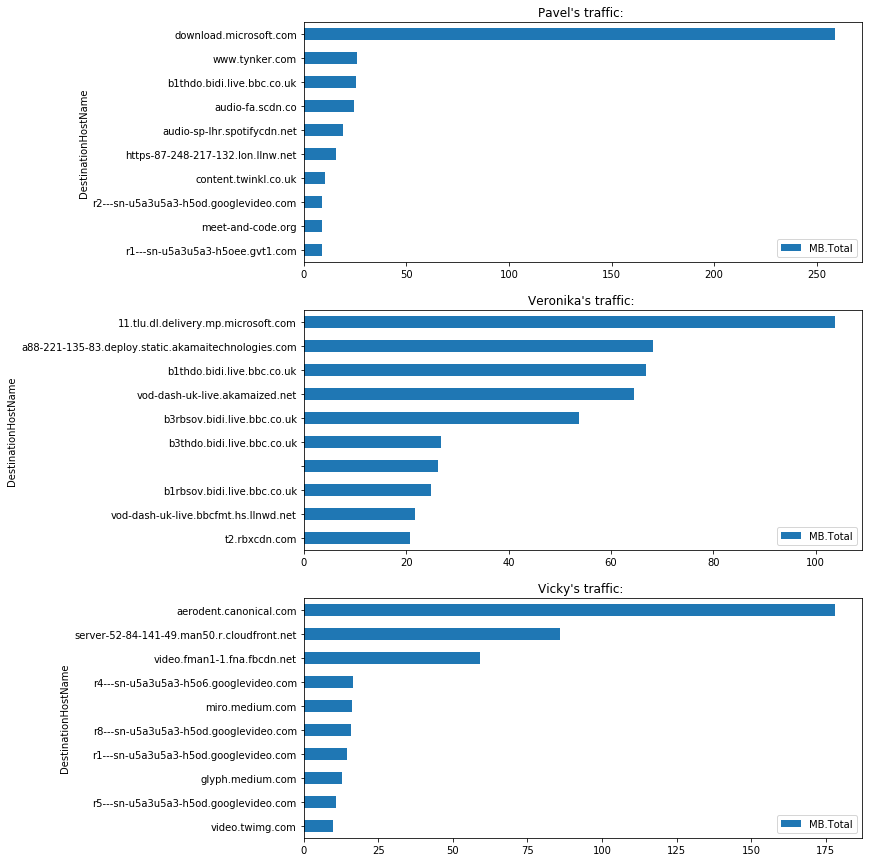

In [7]:
# --- prpare list of users to whom we want collect statistics for:
reporting_users = [user for user in users if user != "NaN"]
# or as an explicit list of names: reporting_users = ["User1", "User2", "User3"]

# --- create subplots to place all graphs at the same figure:
fig, ax = plt.subplots(nrows=len(reporting_users), ncols=1, sharex=False, sharey=False)
fig.set_size_inches(10, 15)

# --- iterate through uach reporting user and build their statistics:
for index, user in enumerate(reporting_users): # conditional for loop : https://stackoverflow.com/questions/12986996/conditional-for-in-python
    user_traffic_per_host  = pd.DataFrame({
        "DestinationHostName": list(df.loc[df["User"] == user].groupby(["Connection.DestinationHostName"]).groups),
        "MB.Total" : list(map(bytes_transform, list(df.loc[df["User"] == user].groupby(["Connection.DestinationHostName"]).agg(np.sum)["Bytes.Total"])))
    })
    user_traffic_per_host.sort_values(by="MB.Total", ascending=True).tail(10).set_index("DestinationHostName").plot(kind="barh", ax=ax[index])
    ax[index].title.set_text("{0}'s traffic: ".format(user))

plt.show()